In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import torch.distributions

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))


Using cpu device


# Data generation

Geometrical figures of random position, shape and color

Random Color:


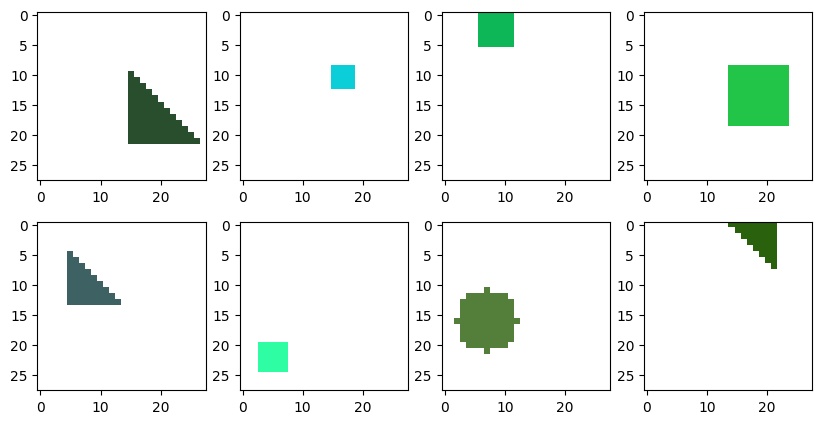

Fixed Color:


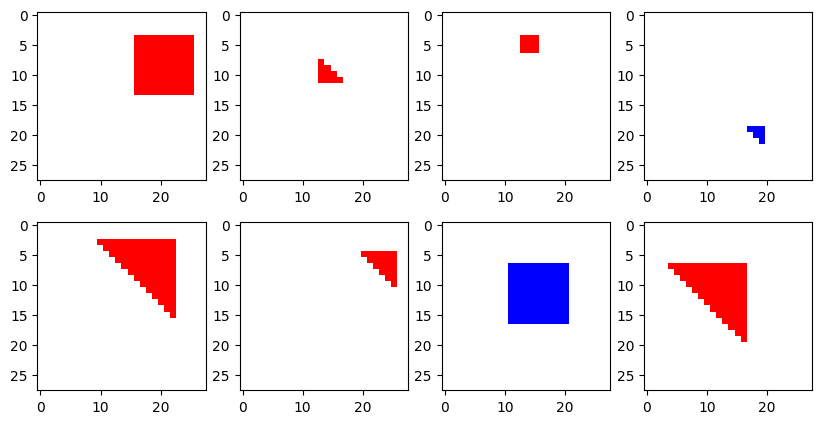

In [67]:


class GeometricFiguresDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=2000, image_size=(28, 28), random_color=True, color_list=None, black_white = False):
        self.num_samples = num_samples
        self.image_size = image_size
        self.random_color = random_color
        self.color_list = color_list
        self.black_white = black_white

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, label = self.generate_image()
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        label_tensor = torch.tensor(label)
        return image_tensor, label_tensor

    def generate_image(self):
        image = np.ones((self.image_size[0], self.image_size[1], 3), dtype=np.uint8) * 255  # White background

        shape = np.random.choice(['square', 'circle', 'triangle'])
        color = self.choose_color()
        size = np.random.randint(3, self.image_size[0] // 2)
        pos_x = np.random.randint(0, self.image_size[1] - size)
        pos_y = np.random.randint(0, self.image_size[0] - size)

        if shape == 'square':
            image = self.draw_square(image, x = pos_x, y = pos_y,  size=size, color=color)
        elif shape=='circle':
            image = self.draw_circle(image, x = pos_x, y = pos_y, radius=size//2, color=color)
        else:
            image = self.draw_triangle(image, x = pos_x, y = pos_y, size=size, color=color)

        #label is the shape, color, size and position of the shape
        shape_dict = {'square': 0, 'circle': 1, 'triangle': 2}
        label = np.array([shape_dict[shape],  size, pos_x, pos_y, color[0], color[1], color[2]])


        return image, label

    def choose_color(self):
        if self.black_white:
            return np.array([0, 0, 0])
        if self.random_color:
            return np.random.randint(0, 256, size=3)  # Random RGB color
        else:
            #return np.random.choice(self.color_list)
            color_r = np.array([255, 0, 0])
            color_g = np.array([0, 255, 0])
            color_b = np.array([0, 0, 255])
            #return one of the three colors
            rand_col = np.random.randint(0, 3)
            if rand_col == 0:
                return color_r
            elif rand_col == 1:
                return color_g
            else:
                return color_b


    def draw_square(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color
        return image

    def draw_triangle(self, image, x, y, size, color):
        image[y:y+size, x:x+size] = color

        # Determine whether to remove upper or lower half of the square
        if np.random.rand() < 0.5:
            # Remove upper half of the square
            for i in range(size):
                for j in range(size):
                    if i > j:
                        image[y+i, x+j] = 255  # Background color
        else:
            # Remove lower half of the square
            for i in range(size):
                for j in range(size):
                    if i < j:
                        image[y+i, x+j] = 255  # Background color
        return image

    def draw_circle(self, image, x, y, radius, color):

        yy, xx = np.ogrid[-y:image.shape[0]-y, -x:image.shape[1]-x]
        mask = xx*xx + yy*yy <= radius*radius
        image[mask] = color
        return image


dataset_random_color = GeometricFiguresDataset(random_color=True)
dataloader_random_color = torch.utils.data.DataLoader(dataset_random_color, batch_size=8, shuffle=True)

dataset_fixed_color = GeometricFiguresDataset(random_color=False, color_list=[[255, 0, 0], [0, 255, 0], [0, 0, 255]])
dataloader_fixed_color = torch.utils.data.DataLoader(dataset_fixed_color, batch_size=8, shuffle=True)

# Visualize some samples with random color
print("Random Color:")
for batch in dataloader_random_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch

# Visualize some samples with fixed color
print("Fixed Color:")
for batch in dataloader_fixed_color:
    batch = batch[0]
    plt.figure(figsize=(10, 5))
    for i in range(batch.size(0)):
        plt.subplot(2, 4, i+1)
        plt.imshow(batch[i].permute(1, 2, 0).numpy())
        #plt.axis('off')
    plt.show()
    break  # Only visualize one batch


In [68]:
batch_size = 25

#dataset = GeometricFiguresDataset(random_color=True)
dataset = GeometricFiguresDataset(random_color=False, black_white=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Convolutional autoencoder

get a sence of how complex our model should be

In [69]:
class Encoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 50):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        
        encoder_channels = [input_channels] + encoder_channels
        self.encoder_channels = encoder_channels

        self.conv_layers = nn.ModuleList()
        for i in range(len(encoder_channels)-1):
            self.conv_layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=2))
            self.conv_layers.append(nn.BatchNorm2d(encoder_channels[i+1]))
            self.conv_layers.append(nn.ReLU())

        self.flatten = nn.Flatten()


    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        self.output_conv_shape = x.shape[1:]

        x = self.flatten(x)

        self.fc = nn.Linear(x.shape[1], self.latent_dim)

        x = self.fc(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, enc_channels, latent_dim, enc_conv_shape):
        super(Decoder, self).__init__()
        self.decoder_channels = enc_channels[::-1]
        
        self.fc = nn.Linear(latent_dim, enc_conv_shape[0]*enc_conv_shape[1]*enc_conv_shape[2])
        self.unflatten = nn.Unflatten(1, enc_conv_shape)

        self.deconv_layers = nn.ModuleList()
        for i in range(len(self.decoder_channels)-1):
            self.deconv_layers.append(nn.ConvTranspose2d(self.decoder_channels[i], self.decoder_channels[i+1], kernel_size=2))
            self.deconv_layers.append(nn.BatchNorm2d(self.decoder_channels[i+1]))
            self.deconv_layers.append(nn.ReLU())

        self.deconv_layers.append(nn.Sigmoid())

    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        for layer in self.deconv_layers:
            x = layer(x)

        return x
    

In [70]:
# #testing 2d transpose conv sizes
# inp = torch.rand(128, 1, 3, 3)

# layers = nn.ModuleList()
# for _ in [4, 8, 16]:
#     layers.append(nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, padding=0))



# for layer in layers:
#     inp = layer(inp)
# print(inp.shape)


In [71]:

class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, encoder_channels, latent_dim = 100):
        super(ConvAutoencoder, self).__init__()
        self.encoder = Encoder(input_channels, encoder_channels, latent_dim = latent_dim)
        encoder_channels = [3, 4, 8, 16]
        latent_dim = latent_dim
        output_conv_shape = torch.Size([16, 25, 25])
        self.decoder = Decoder(encoder_channels, latent_dim, output_conv_shape)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


torch.Size([25, 3, 28, 28])


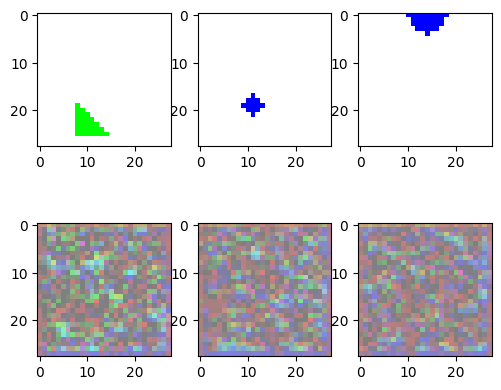

In [72]:

# Define model parameters
input_channels = 3  # RGB channels
encoder_channels = [4, 8, 16, 32]    #shpuld be like 8,16,32 ...
latent_dim = 250

# Initialize the model
model = ConvAutoencoder(input_channels, encoder_channels, latent_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()



# test for random input batch
#random_batch = torch.rand((128, 3, 28, 28))
#output = model(random_batch)

random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)

print(output.shape)
assert output.shape == random_batch.shape


plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    

In [77]:
# Training loop
optimizer = optim.Adam(model.parameters(), lr=1e-2)

num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader_random_color.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/25], Loss: 0.1294
Epoch [2/25], Loss: 0.0765
Epoch [3/25], Loss: 0.0573
Epoch [4/25], Loss: 0.0494
Epoch [5/25], Loss: 0.0467
Epoch [6/25], Loss: 0.0451


KeyboardInterrupt: 

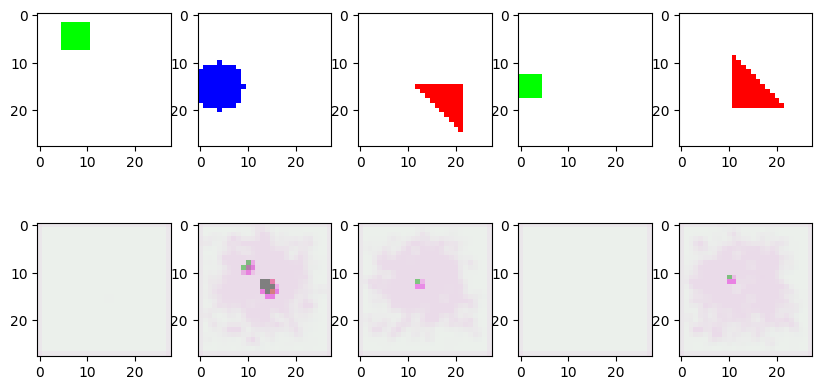

In [78]:
random_batch = next(iter(dataloader))
random_batch = random_batch[0].to(device)
output = model(random_batch)

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(random_batch[i].permute(1, 2, 0).cpu().detach().numpy())
    plt.subplot(2, 5, i+6)
    plt.imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    

In [81]:
(output[0]/output[1]).min()

tensor(0.9900, grad_fn=<MinBackward1>)